In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
import pandas as pd

# Load the pre-trained ResNet model
model = models.resnet18(pretrained=True)
model.eval()

# Define the transform to preprocess the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the images from the dataset
dataset_path = r"D:\MTECH\PROJECT\RL - FINAL\DATA\TEST"  # Replace with the path to your dataset
image_paths = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith(".jpg")]

images = []
for image_path in image_paths:
    image = Image.open(image_path)
    image = preprocess(image)
    images.append(image)

# Create a batch tensor from the images
batch = torch.stack(images)

# Make the predictions
with torch.no_grad():
    output = model(batch)

# Get the predicted class labels
_, predicted_indices = torch.max(output, 1)
predicted_labels = predicted_indices.tolist()

# Create a dataframe with image names and predicted class labels
data = {'Image': image_paths, 'PredictedLabel': predicted_labels}
df = pd.DataFrame(data)


In [3]:
df

,Image,PredictedLabel
0,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\00000075...,421
1,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\00000076...,881
2,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\00000077...,765
3,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\00000078...,765
4,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\dalmatia...,251
5,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\dalmatia...,251
6,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\dalmatia...,251
7,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\img_144.jpg,111
8,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\img_147.jpg,68
9,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\img_19.jpg,714


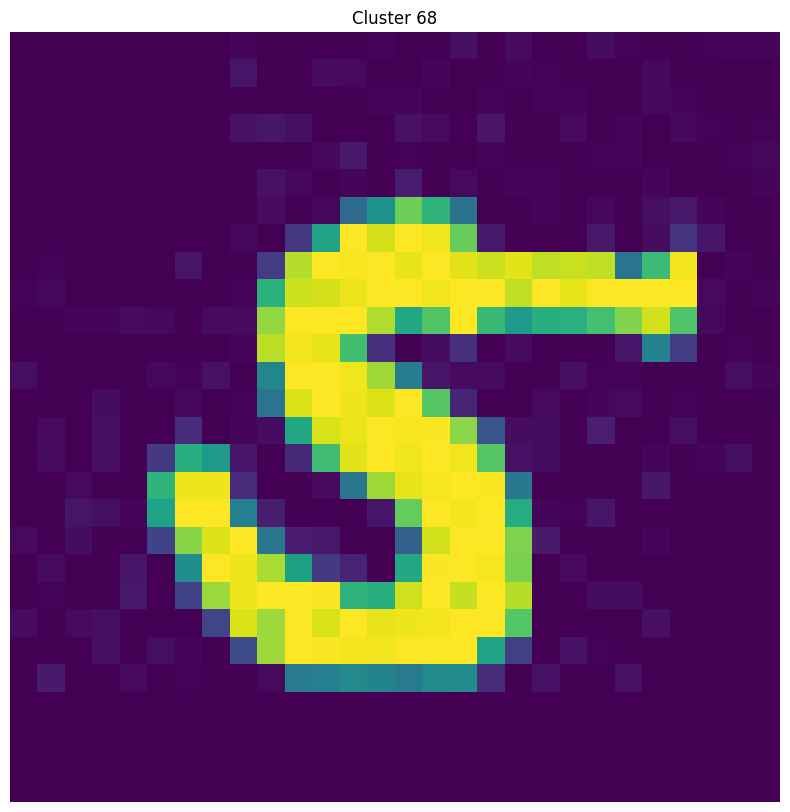

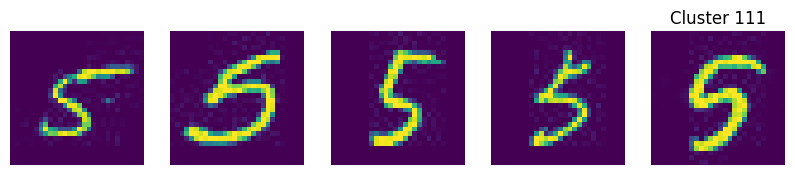

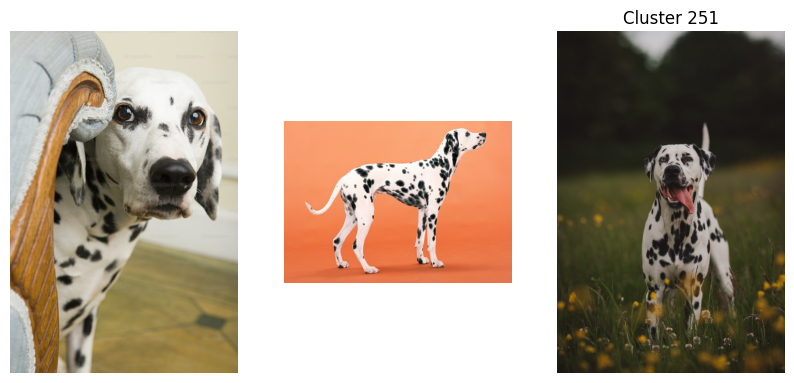

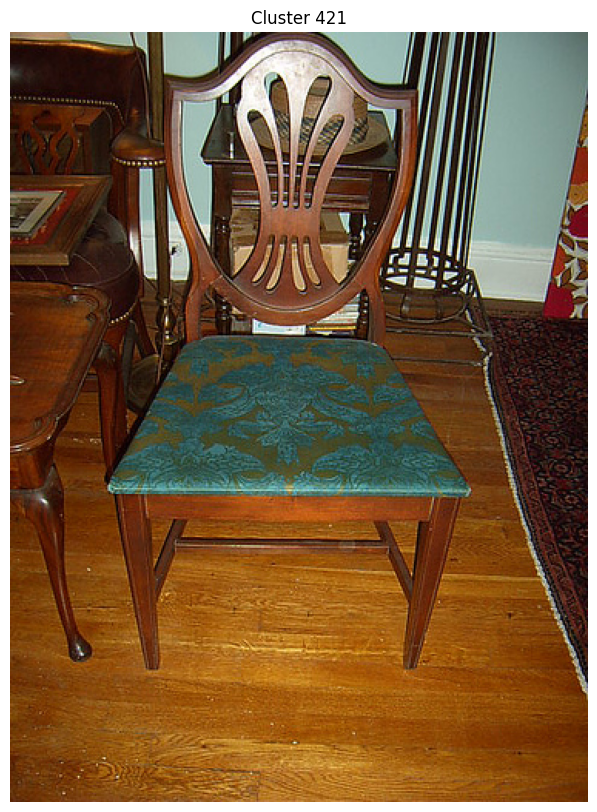

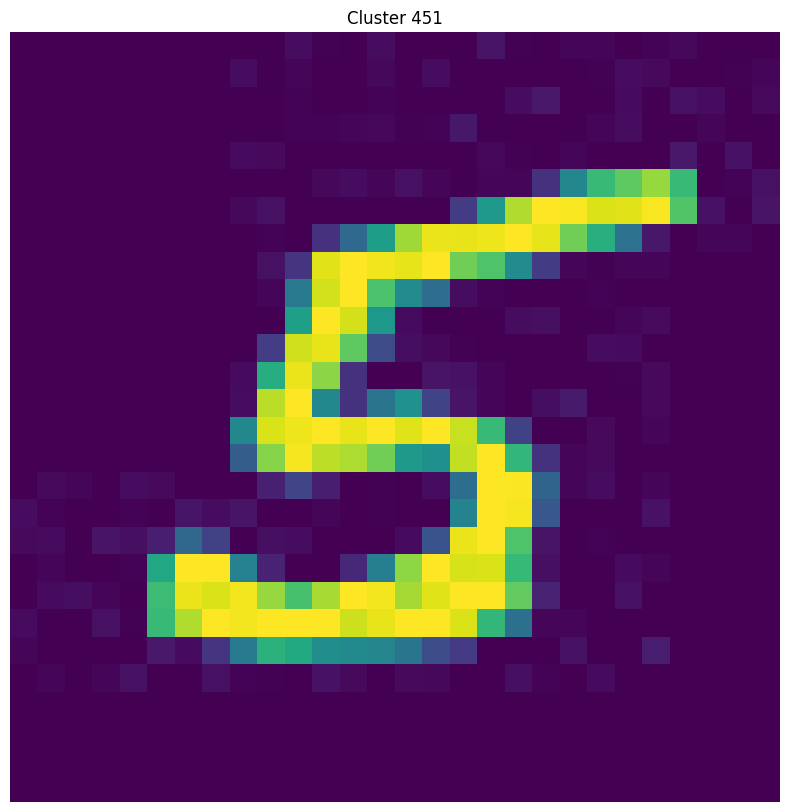

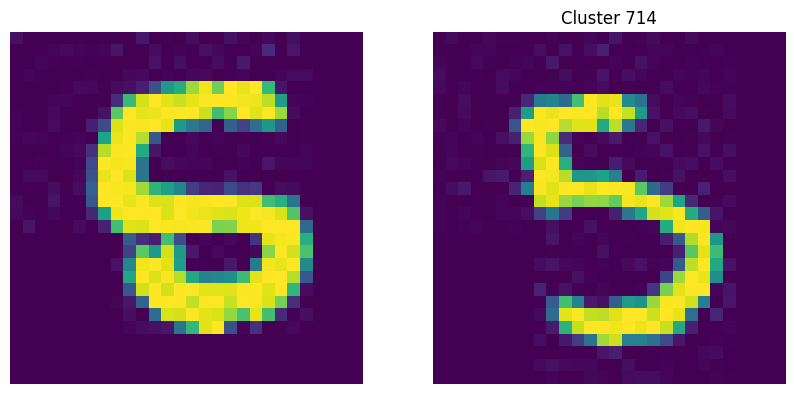

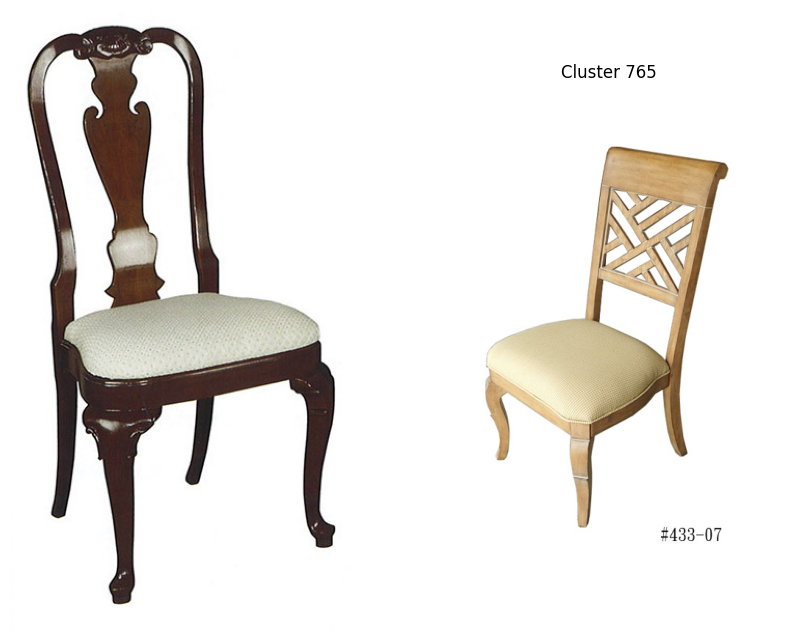

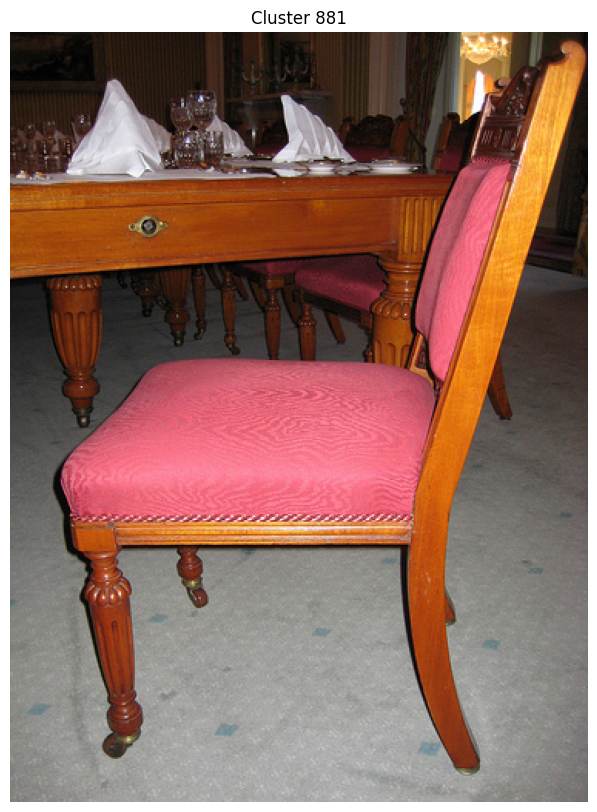

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
# Group the dataframe by predicted labels
groups = df.groupby('PredictedLabel')

# Plot the images for each cluster
for label, group in groups:
    cluster_images = group['Image'].tolist()
    num_images = len(cluster_images)

    # Create a figure to plot the images
    fig = plt.figure(figsize=(10, 10))

    # Plot each image in the cluster
    for i in range(num_images):
        image_path = cluster_images[i]
        image = Image.open(image_path)
        ax = fig.add_subplot(1, num_images, i + 1)
        ax.imshow(image)
        ax.axis('off')

    # Set the title as the predicted label
    ax.set_title(f'Cluster {label}')

    # Show the plot
    plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the source and target domains
source_dataset = datasets.MNIST(root='D:\MTECH\PROJECT\RL - FINAL\DATA\MNIST', train=True, download=True,
                               transform=transforms.ToTensor())
target_dataset = datasets.MNIST(root='D:\MTECH\PROJECT\RL - FINAL\DATA\MNISTM', train=True, download=True,
                               transform=transforms.ToTensor())

# Set up data loaders
source_loader = DataLoader(source_dataset, batch_size=64, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=64, shuffle=True)

# Define the model
class DomainAdaptationModel(nn.Module):
    def __init__(self):
        super(DomainAdaptationModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 48, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(48 * 4 * 4, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(48 * 4 * 4, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )
    
    def forward(self, x, alpha):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        class_output = self.classifier(features)
        domain_output = self.domain_classifier(features)
        return class_output, domain_output

# Initialize the model
model = DomainAdaptationModel()

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
alpha = 0.1  # Gradient reversal layer scaling factor
for epoch in range(num_epochs):
    loop = tqdm(zip(source_loader, target_loader), total=min(len(source_loader), len(target_loader)))
    for i, ((source_data, source_labels), (target_data, _)) in enumerate(loop):
        source_images = source_data
        target_images = target_data
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass on source domain
        source_class_output, source_domain_output = model(source_images, alpha)
        source_class_loss = loss_fn(source_class_output, source_labels)
        source_domain_labels = torch.zeros(source_images.size(0)).long()  # Source domain label is 0
        source_domain_loss = loss_fn(source_domain_output, source_domain_labels)
        
        # Forward pass on target domain
        _, target_domain_output = model(target_images, alpha)
        target_domain_labels = torch.ones(target_images.size(0)).long()  # Target domain label is 1
        target_domain_loss = loss_fn(target_domain_output, target_domain_labels)
        
        # Overall loss
        total_loss = source_class_loss + source_domain_loss + target_domain_loss
        
        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()
        
        loop.set_postfix(total_loss=total_loss.item())

# Save the model
torch.save(model.state_dict(), 'domain_adaptation_model.pth')

# Load the saved model
model.load_state_dict(torch.load('D:\MTECH\PROJECT\RL - FINAL\domain_adaptation_model.pth'))
model.eval()


 83%|████████▎ | 779/938 [01:47<00:21,  7.28it/s, total_loss=1.51]


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

# Define the target domain dataset
target_dataset = datasets.MNIST(root='D:\MTECH\PROJECT\RL - FINAL\DATA\MNISTM', train=False, download=True,
                               transform=transforms.ToTensor())

# Set up data loader for the target domain
target_loader = DataLoader(target_dataset, batch_size=64, shuffle=False)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to calculate accuracy of the model
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            _, outputs = model(images, alpha)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

# Function to generate classification report
def get_classification_report(model, data_loader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            _, outputs = model(images, alpha)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    report = classification_report(y_true, y_pred)
    return report

# Calculate accuracy on the target domain
accuracy = get_accuracy(model, target_loader)
print("Accuracy on the target domain:", accuracy)

# Generate classification report on the target domain
report = get_classification_report(model, target_loader)
print("Classification Report:")
print(report)


Accuracy on the target domain: 0.0977
Classification Report:
              precision    recall  f1-score   support

           0       0.10      1.00      0.18       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



c:\Users\rahul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rahul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rahul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
import pandas as pd

# Load the pre-trained ResNet model
model = models.resnet18(pretrained=True)
model.eval()

# Define the transform to preprocess the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the images from the dataset
dataset_path = r"D:\MTECH\PROJECT\RL - FINAL\DATA\TEST"  # Replace with the path to your dataset
image_paths = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith(".jpg")]

images = []
for image_path in image_paths:
    image = Image.open(image_path)
    image = preprocess(image)
    images.append(image)

# Create a batch tensor from the images
batch = torch.stack(images)

# Make the predictions
with torch.no_grad():
    output = model(batch)

# Get the predicted class labels
_, predicted_indices = torch.max(output, 1)
predicted_labels = predicted_indices.tolist()

# Define the known classes (MNIST or MNISTM)
known_classes = ['MNIST', 'MNISTM']

# Create a dataframe with image names and predicted class labels
data = {'Image': image_paths, 'PredictedLabel': predicted_labels}
df = pd.DataFrame(data)

# Assign labels as known class if they belong to MNIST or MNISTM, otherwise assign as unknown class
df['Label'] = df['PredictedLabel'].apply(lambda x: 'Known' if x in known_classes else 'Unknown')


c:\Users\rahul\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rahul\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
df

,Image,PredictedLabel,Label
0,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\00000075...,421,Unknown
1,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\00000076...,881,Unknown
2,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\00000077...,765,Unknown
3,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\00000078...,765,Unknown
4,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\dalmatia...,251,Unknown
5,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\dalmatia...,251,Unknown
6,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\dalmatia...,251,Unknown
7,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\img_144.jpg,111,Unknown
8,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\img_147.jpg,68,Unknown
9,D:\MTECH\PROJECT\RL - FINAL\DATA\TEST\img_19.jpg,714,Unknown


In [8]:
known_label_count = df[df['Label'] == 'Known'].shape[0]
print("Number of known labels:", known_label_count)


Number of known labels: 0
